Previous model saw poorer performance after nearly doubling the image size. For this model, I will increase the image size significantly through augmentation.
I will add a total of 5000 images with the majority being positive.

In [1]:
%load_ext autoreload
%autoreload 2
from misc import project_utils

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint

RANDOM_SEED = 0
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001
ES_PATIENCE = 10
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = False

In [2]:
df_train = project_utils.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,152.0,140.0,397.0,346.0
1,00002.jpg,1.0,144.0,140.0,403.0,345.0
2,00003.jpg,1.0,142.0,138.0,402.0,346.0
3,00004.jpg,1.0,144.0,140.0,405.0,344.0
4,00005.jpg,1.0,141.0,140.0,407.0,344.0
...,...,...,...,...,...,...
7994,07995.jpg,1.0,89.0,415.0,466.0,794.0
7995,07996.jpg,1.0,162.0,230.0,504.0,493.0
7996,07997.jpg,1.0,69.0,365.0,414.0,660.0
7997,07998.jpg,1.0,114.0,447.0,444.0,744.0


In [3]:
df_test = project_utils.load_image_dataframes('./data/test/', 'annotations.json')
display(df_test)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,220.0,252.0,411.0,437.0
1,00002.jpg,1.0,217.0,241.0,402.0,432.0
2,00003.jpg,1.0,229.0,252.0,416.0,443.0
3,00004.jpg,1.0,243.0,317.0,425.0,487.0
4,00005.jpg,1.0,274.0,332.0,457.0,510.0
...,...,...,...,...,...,...
107,00108.jpg,0.0,0.0,0.0,0.0,0.0
108,00109.jpg,0.0,0.0,0.0,0.0,0.0
109,00110.jpg,0.0,0.0,0.0,0.0,0.0
110,00111.jpg,0.0,0.0,0.0,0.0,0.0


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory='./data/train/', 
    x_col='id', 
    y_col=['confidence', 'y1', 'x1', 'y2', 'x2'], 
    subset='training', 
    batch_size=BATCH_SIZE, 
    seed=RANDOM_SEED, 
    shuffle=True, 
    class_mode='raw', 
    target_size=(224, 224), 
    color_mode='rgb')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory='./data/train/', 
    x_col='id', 
    y_col=['confidence', 'y1', 'x1', 'y2', 'x2'], 
    subset='validation', 
    batch_size=BATCH_SIZE, 
    seed=RANDOM_SEED, 
    shuffle=True, 
    class_mode='raw', 
    target_size=(224, 224), 
    color_mode='rgb')

Found 6400 validated image filenames.
Found 1599 validated image filenames.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test, 
    directory='./data/test/', 
    x_col='id', 
    y_col=['confidence', 'y1', 'x1', 'y2', 'x2'], 
    batch_size=BATCH_SIZE, 
    seed=RANDOM_SEED, 
    shuffle=True, 
    class_mode='raw', 
    target_size=(224, 224), 
    color_mode='rgb')

Found 112 validated image filenames.


80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
200/200 [==============================] - 72s 303ms/step - loss: 90111.5319 - iou_metric: 0.0478 - val_loss: 26256.0352 - val_iou_metric: 0.1861
Epoch 2/100
200/200 [==============================] - 49s 244ms/step - loss: 24514.3279 - iou_metric: 0.1917 - val_loss: 22130.2715 - val_iou_metric: 0.2568
Epoch 3/100
200/200 [==============================] - 49s 243ms/step - loss: 19102.2356 - iou_metric: 0.2569 - val_loss: 19043.9941 - val_iou_metric: 0.3371
Epoch 4/100
200/200 [==============================] - 49s 244ms/step - loss: 15683.5313 - iou_metric: 0.3230 - val_loss: 16361.6406 - val_iou_metric: 0.3780
Epoch 5/100
200/200 [==============================] - 49s 246ms/step - loss: 11859.1737 - iou_metric: 0.3862 - val_loss: 13985.9971 - val_iou_metric: 0.3859
Epoch 6/100
200/200 [==============================] - 49s 245ms/step - loss: 9963.2388 - iou_metric: 0.4158 - val_loss: 12316.8330 - val_iou_met

KeyError: 'confidence_metric'

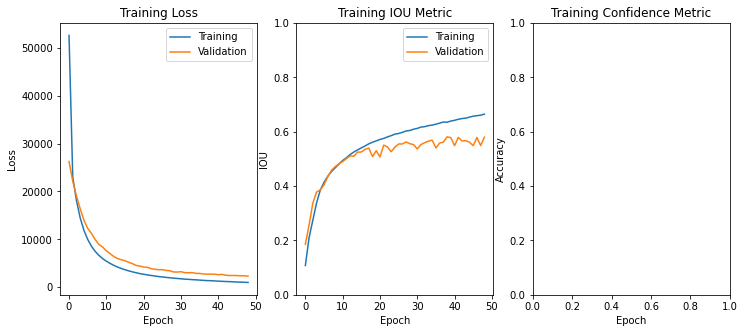

In [6]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)
bbHead = keras.layers.Dense(1024, activation='relu')(flatten)

bbHead = keras.layers.Dense(5, activation='linear', name='bounding_output')(bbHead)



model = keras.models.Model(inputs=vgg.input, outputs=bbHead)
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=opt, metrics=[project_utils.iou_metric])

es = EarlyStopping(monitor='val_iou_metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=[es])
project_utils.plot_history(history)

train_results = model.evaluate(train_generator)
validation_results = model.evaluate(validation_generator)
test_results  = model.evaluate(test_generator)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[1]))
print('Testing Loss: {}\nTesting IOU: {}'.format(test_results[0], test_results[1]))

project_utils.write_results('./history.txt', model, history, train_generator.n, validation_generator.n)

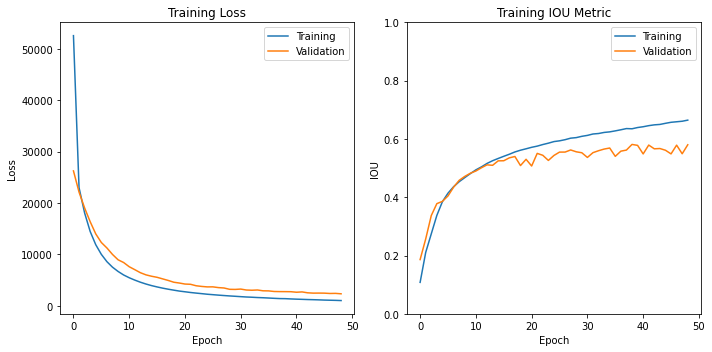

4/4 [==============================] - 1s 150ms/step - loss: 6515.3398 - iou_metric: 0.3283
Training Loss: 1317.15380859375
Training IOU: 0.6407732963562012
Validation Loss: 2749.6357421875
Validation IOU: 0.5812187790870667
Testing Loss: 6515.33984375
Testing IOU: 0.32834678888320923


In [18]:
project_utils.plot_history(history)
train_results = model.evaluate(train_generator)
validation_results = model.evaluate(validation_generator)
test_results  = model.evaluate(test_generator)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[1]))
print('Testing Loss: {}\nTesting IOU: {}'.format(test_results[0], test_results[1]))

project_utils.write_results('./history.txt', model, history, train_generator.n, validation_generator.n)

In [19]:
PLAY_VIDEOS = True

NameError: name 'output' is not defined

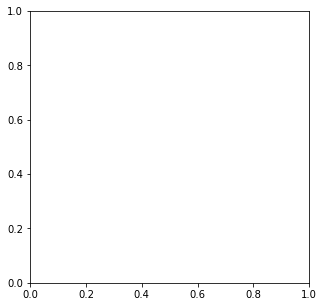

In [21]:
if PLAY_VIDEOS:
    display(project_utils.play_images_from_datagen(train_generator, model=model, threshold=0.25, num_to_iter=500))

In [ ]:
if PLAY_VIDEOS:
    display(project_utils.play_images_from_datagen(validation_generator, model=model, scale_down=True, threshold=0.25, num_to_iter=50))

In [ ]:
if PLAY_VIDEOS:
    display(project_utils.play_images_from_datagen(test_generator, model=model, scale_down=True, threshold=0.25))

In [ ]:
if PLAY_VIDEOS:
    display(project_utils.play_images_from_video('../../data/original/test_videos/hand_signs_webcam.mp4', model=model, threshold=0.25))

In [ ]:
if PLAY_VIDEOS:
    display(project_utils.play_images_from_video('../../data/original/test_videos/hand_signs_hand_only.mp4', model=model, threshold=0.25))